<a href="https://colab.research.google.com/github/prtk0007/Chest_Xray_detection/blob/exp_binary/Project_ray_7_Inception_acc_90_70_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
# # !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images
!unzip \*.zip

In [25]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
#from keras.applications.resnet50 import ResNet50
#from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

In [26]:
incept3=InceptionV3(input_shape=(180,180,3),
                             include_top=False,
                             weights='imagenet')
#freazing the trained layers
for layers in incept3.layers:
    layers.trainable=False

In [27]:
last_layer=incept3.get_layer('mixed10')
last_output = last_layer.output

In [28]:
from keras.layers import Dropout
x=Flatten()(last_output)
x=Dense(1024,activation='relu')(x)
x=Dropout(0.4)(x)
x=Dense(256,activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(1,activation='sigmoid')(x)

model3=Model(incept3.input,x)
from keras.optimizers import Adam
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
               metrics=['accuracy'])
# model4.summary()

In [29]:
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 89, 89, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 89, 89, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 89, 89, 32)   0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [9]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   rotation_range = 20,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255) 
val_datagen = ImageDataGenerator(rescale = 1./255)

In [30]:
training_set = train_datagen.flow_from_directory('/content/train',
                                                 target_size = (180, 180),
                                                 batch_size = 64,
                                                 class_mode = 'binary')

Found 4192 images belonging to 2 classes.


In [31]:
test_set = test_datagen.flow_from_directory('/content/test',
                                            target_size = (180, 180),
                                            batch_size = 64,
                                            shuffle=False,
                                            class_mode = 'binary')

val_set = test_datagen.flow_from_directory('/content/val',
                                            target_size = (180, 180),
                                            batch_size = 64,
                                            shuffle=False,
                                            class_mode = 'binary')

Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


In [32]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
early = EarlyStopping(monitor='val_loss', mode='min', patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience =  4 , verbose=1,factor=0.01, min_lr=0.0001)
callbacks_list = [ early, learning_rate_reduction]

In [33]:
r3=model3.fit(training_set,validation_data=val_set,epochs=25,verbose=2,callbacks=callbacks_list)

Epoch 1/25
66/66 - 78s - loss: 4.6538 - accuracy: 0.7956 - val_loss: 0.9982 - val_accuracy: 0.6625
Epoch 2/25
66/66 - 72s - loss: 0.5145 - accuracy: 0.8714 - val_loss: 0.2491 - val_accuracy: 0.9154
Epoch 3/25
66/66 - 72s - loss: 0.3016 - accuracy: 0.8924 - val_loss: 0.2089 - val_accuracy: 0.9471
Epoch 4/25
66/66 - 72s - loss: 0.2437 - accuracy: 0.9148 - val_loss: 0.1988 - val_accuracy: 0.9298
Epoch 5/25
66/66 - 71s - loss: 0.2214 - accuracy: 0.9151 - val_loss: 0.1829 - val_accuracy: 0.9337
Epoch 6/25
66/66 - 71s - loss: 0.2193 - accuracy: 0.9175 - val_loss: 0.1950 - val_accuracy: 0.9308
Epoch 7/25
66/66 - 71s - loss: 0.2214 - accuracy: 0.9179 - val_loss: 0.1789 - val_accuracy: 0.9471
Epoch 8/25
66/66 - 72s - loss: 0.2050 - accuracy: 0.9194 - val_loss: 0.1417 - val_accuracy: 0.9519
Epoch 9/25
66/66 - 71s - loss: 0.1829 - accuracy: 0.9344 - val_loss: 0.1421 - val_accuracy: 0.9510
Epoch 10/25
66/66 - 71s - loss: 0.1730 - accuracy: 0.9339 - val_loss: 0.1544 - val_accuracy: 0.9452
Epoch 11/

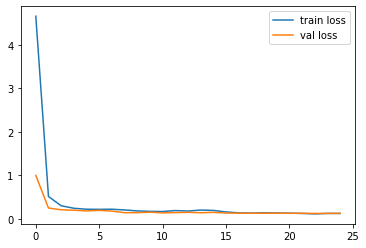

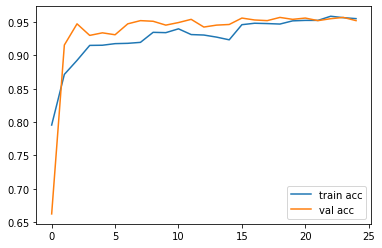

<Figure size 432x288 with 0 Axes>

In [34]:
plt.plot(r3.history['loss'], label='train loss')
plt.plot(r3.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r3.history['accuracy'], label='train acc')
plt.plot(r3.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [35]:
model3.evaluate(test_set)

10/10 [==============================] - 5s 448ms/step - loss: 0.3227 - accuracy: 0.9038


[0.32272154092788696, 0.9038461446762085]

In [36]:
preds = model3.predict(test_set,verbose=1)

10/10 [==============================] - 6s 474ms/step


In [37]:
predictions = preds.copy()
predictions[predictions <= 0.75] = 0
predictions[predictions > 0.75] = 1

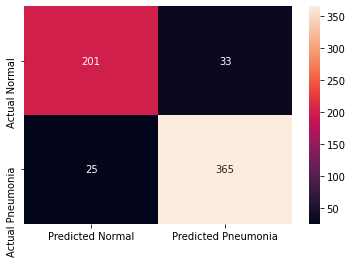

In [38]:
from sklearn.metrics import classification_report,confusion_matrix

cm = pd.DataFrame(data=confusion_matrix(test_set.classes, predictions, labels=[0, 1]),
                  index=["Actual Normal", "Actual Pneumonia"],
                  columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [39]:
 print(classification_report(y_true=test_set.classes, y_pred=predictions,
                            target_names =['NORMAL','PNEUMONIA']
 ))

              precision    recall  f1-score   support

      NORMAL       0.89      0.86      0.87       234
   PNEUMONIA       0.92      0.94      0.93       390

    accuracy                           0.91       624
   macro avg       0.90      0.90      0.90       624
weighted avg       0.91      0.91      0.91       624



In [42]:
cd /content/drive/MyDrive/Kaggle

/content/drive/MyDrive/Kaggle


chest_xray		  drive		    kaggle.json
chest-xray-pneumonia.zip  Inceptv3_xray.h5  sample_data


In [43]:
model3.save('Inceptv3_xray_acc91_f187.h5')

In [ ]:
from keras.models import load_model

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model3 = load_model('/content/drive/MyDrive/Kaggle/Inceptv3_xray.h5')

In [ ]:
import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
from keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.applications.resnet50 import ResNet50
#from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
TRAIN_DIR = "/content/chest_xray/chest_xray/train/"
TEST_DIR =  "/content/chest_xray/chest_xray/test/"

In [ ]:
def get_label(Dir):
    for nextdir in os.listdir(Dir):
        if not nextdir.startswith('.'):
            if nextdir in ['NORMAL']:
                label = 0
            elif nextdir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
    return nextdir, label

In [ ]:
def preprocessing_data(Dir):
    X = []
    y = []
    
    for nextdir in os.listdir(Dir):
        nextdir, label = get_label(Dir)
        temp = Dir + nextdir
        
        for image_filename in tqdm(os.listdir(temp)):
            path = os.path.join(temp + '/' , image_filename)
            img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = skimage.transform.resize(img, (180, 180, 3))
                img = np.asarray(img)
                X.append(img)
                y.append(label)
            
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X,y

In [ ]:
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
        if not nextDir.startswith('.'):
            if nextDir in ['NORMAL']:
                label = 0
            elif nextDir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
                
            temp = Dir + nextDir
                
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (180, 180, 3))
                    #img_file = scipy.misc.imresize(arr=img_file, size=(150, 150, 3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [ ]:
X_test , y_test = get_data(TEST_DIR)

100%|██████████| 234/234 [01:39<00:00,  2.35it/s]


In [ ]:
from keras.utils.np_utils import to_categorical
y_test = to_categorical(y_test)


In [ ]:
y_test[5]

array([0., 1.], dtype=float32)

In [ ]:
from sklearn.metrics import confusion_matrix
pred = model3.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

In [ ]:
y_true

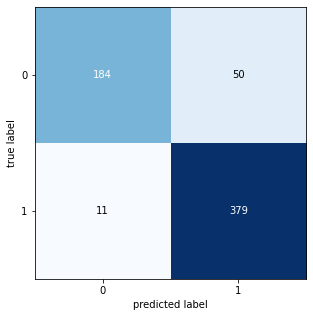

In [ ]:
cm = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5))
plt.show()

In [ ]:
print('True Positive  (TP) = ', cm[1][1])
print('False Positive (FP) = ', cm[0][1])
print('False Negative (FN) = ', cm[1][0])
print('True Negative  (TN) = ', cm[0][0])
print('-'*26)

True Positive  (TP) =  379
False Positive (FP) =  50
False Negative (FN) =  11
True Negative  (TN) =  184
--------------------------


In [ ]:
if (cm[0][0] + cm[0][1])!=0 and (cm[0][0], cm[1][0])!=0:
      precision= round((cm[0][0] / (cm[0][0] + cm[0][1]))*100, 2) 
      recall   = round((cm[0][0] / (cm[0][0] + cm[1][0]))*100, 2) 
      f1_score = round(2*((precision*recall)/(precision+recall)), 2)       
      print(f'Precision Score: {precision}%')
      print(f'Recall Score: {recall}%')
      print(f'F1 Score: {f1_score}%')
      print('='*50) 
      print('\n')

Actual class: PNEUMONIA
Predicted class: Pneumonia


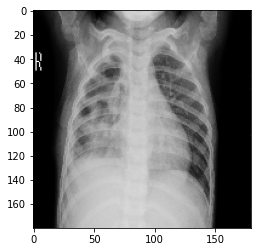

In [ ]:
import random
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

def choose_image_and_predict():
    normal_or_pneumonia = ['NORMAL', 'PNEUMONIA']
    folder_choice = (random.choice(normal_or_pneumonia))
    
    pneumonia_images = glob('/content/chest_xray/chest_xray/val/'+folder_choice+'/*')
    img_choice = (random.choice(pneumonia_images))

    img = load_img(img_choice, target_size=(180, 180))
    img = img_to_array(img)
    plt.imshow(img / 255.)
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    pred = model3.predict(x)
    pred_class = pred.argmax(axis=-1)
    print("Actual class:", folder_choice)
    if pred_class[0] == 0:
        print("Predicted class: Normal")
    else:
        print("Predicted class: Pneumonia")
               
        
choose_image_and_predict()

Predicted class: Pneumonia


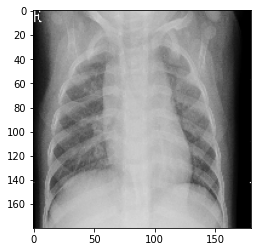

In [ ]:
img = image.load_img('/content/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg', target_size=(180,180))
plt.imshow(img)
x=image.img_to_array(img)
x=np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model3.predict(img_data)
if classes[0][0] > 0.8:
        print("Predicted class: Normal")
else:
        print("Predicted class: Pneumonia")

0.023549343